# Logistic Regression with a Neural Network Mindset

Welcome! This notebook is a personal project, part of the [Deep Learning Specialization](https://www.deeplearning.ai/) by **Andrew Ng**, developed by DeepLearning.AI.

In this project, we build a binary image classifier to recognize whether an image contains a **cat** or **not** using **logistic regression** implemented from scratch — but structured with a **neural network mindset**.


### 🔌 Importing Libraries

In this cell, we import all the Python libraries required for this notebook.

- `numpy` is used for handling arrays and vectorized operations
- `copy` is used to safely duplicate parameter objects
- `matplotlib.pyplot` is for visualizing data (especially images and learning curves)
- `h5py` is for reading the dataset stored in `.h5` format
- `scipy` and `PIL.Image` help with processing and testing external images
- `%matplotlib inline` ensures plots are rendered inside the notebook
- `%autoreload 2` reloads modules automatically when code changes are detected

These imports are foundational for everything we will implement below.


In [23]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Dataset

We now load the dataset containing images of cats and non-cats. The data is stored in `.h5` files — a hierarchical data format ideal for large and structured datasets.

Each image in the dataset is a **color image** of shape `(64, 64, 3)`:
- `64 x 64` pixels
- `3` color channels (RGB)

The dataset is composed of:
- `train_set_x_orig`: training images
- `train_set_y`: labels for training images (1 = cat, 0 = non-cat)
- `test_set_x_orig`: test images
- `test_set_y`: labels for test images
- `classes`: string labels (e.g., `b'cat'`, `b'non-cat'`)

We load all this into NumPy arrays using the `h5py` library and verify the shapes of the datasets to confirm successful import.


In [24]:
train_dataset_path = "datasets/train_catvnoncat.h5"
test_dataset_path = "datasets/test_catvnoncat.h5"

# Loading the training dataset
with h5py.File(train_dataset_path, 'r') as train_dataset:
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y = np.array(train_dataset["train_set_y"][:]) 
    classes = np.array(train_dataset["list_classes"][:])
    
with h5py.File(test_dataset_path, 'r') as test_dataset:
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y = np.array(test_dataset["test_set_y"][:])
    

print("train_set_x_orig shape:", train_set_x_orig.shape)
print("train_set_y shape:", train_set_y.shape)
print("test_set_x_orig shape:", test_set_x_orig.shape)
print("test_set_y shape:", test_set_y.shape)

train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (209,)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (50,)


## Exploring Dataset Dimensions

Before building the model, it's important to understand the structure of our data.

We extract the following key values:
- `m_train`: number of training examples
- `m_test`: number of test examples
- `num_px`: height (and width) of each image (since the images are square)

We also display the shape of the original image arrays to verify:
- The shape of the training and test sets
- That each image is represented as a 3D array (height × width × 3 for RGB)

This step ensures that we understand what input the model will receive and how to reshape or normalize it properly.


In [25]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209,)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50,)


## Data Preprocessing - Flattening and Reshaping

To feed the image data into our logistic regression model, we must flatten each image into a 1D vector.

Each image has shape `(num_px, num_px, 3)` → we reshape it into a column vector of shape `(num_px * num_px * 3, 1)`.  
This transformation is done for all `m` examples at once, resulting in:
- `train_set_x_flatten`: shape `(12288, m_train)`
- `test_set_x_flatten`: shape `(12288, m_test)`

We also reshape the labels to match the expected shape:
- From `(m,)` to `(1, m)` for both `train_set_y` and `test_set_y`

This ensures compatibility for matrix operations during forward and backward propagation.


In [26]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, num_px*num_px*3).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, num_px*num_px*3).T
train_set_y = train_set_y.reshape(1, m_train)
test_set_y = test_set_y.reshape(1, m_test)

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


## Data Normalization

Pixel values in images range from **0 to 255**. To ensure faster and more stable convergence during training, it's common practice to **normalize the data** by scaling the pixel values to a [0, 1] range.

This is done by dividing each pixel value by 255:

```python
X_normalized = X / 255.


In [27]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

print("train_set_x min/max:", train_set_x.min(), train_set_x.max())
print("test_set_x min/max:", test_set_x.min(), test_set_x.max())

train_set_x min/max: 0.0 1.0
test_set_x min/max: 0.0 1.0


## Sigmoid Activation Function

The **sigmoid function** transforms any real-valued number into a value between **0 and 1**, making it ideal for binary classification problems.

It is defined as:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

In the context of logistic regression, the sigmoid function outputs the **probability that the input belongs to the positive class** (e.g., "cat").

This function will be used to compute the activation `A = sigmoid(wᵀx + b)` in forward propagation.


In [6]:
def sigmoid(z):
    
    s = 1/(1+np.exp(-z))
    
    return s

## Initializing Parameters with Zeros

Before training our logistic regression model, we need to initialize the parameters `w` (weights) and `b` (bias).

Since logistic regression is a convex optimization problem, initializing the weights with zeros will **not affect convergence** — unlike in deep neural networks, where zero initialization can cause symmetry issues.

In this implementation:
- `w` is initialized as a column vector of zeros with shape `(dim, 1)`
- `b` is initialized as a scalar `0.0`

These parameters will be updated during gradient descent.


In [8]:
def initialize_with_zeros(dim):
    
    w = np.zeros((dim,1))
    b = 0.0

    return w, b

## Forward and Backward Propagation

This function implements the two main steps of learning in logistic regression:

### 1. Forward Propagation:
- Computes the predicted probabilities using the sigmoid activation:
  $$ A = \sigma(w^T X + b) $$
- Computes the **log-likelihood cost**:
  $$ J = -\frac{1}{m} \sum \left[ y \log(a) + (1 - y)\log(1 - a) \right] $$

### 2. Backward Propagation:
- Calculates the gradients of the cost with respect to `w` and `b`:
  - $$ dw = \frac{1}{m} X (A - Y)^T $$
  - $$ db = \frac{1}{m} \sum (A - Y) $$

These gradients will be used to update the parameters during optimization.

The function returns:
- `grads`: dictionary containing `dw` and `db`
- `cost`: the scalar value of the current cost


In [28]:
def propagate(w, b, X, Y):
        
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X)+b)
    cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    
    dw = 1/m * np.dot(X, (A-Y).T)
    db = 1/m * np.sum(A-Y)
   
    cost = np.squeeze(np.array(cost))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

## Optimization - Gradient Descent

This function performs **gradient descent** to minimize the cost function and update the parameters `w` and `b`.

### What happens in each iteration:
1. **Forward and backward propagation** is called via `propagate()` to compute the cost and gradients.
2. **Parameters are updated** using the gradient descent rules:
   - $$ w := w - \alpha \cdot dw $$
   - $$ b := b - \alpha \cdot db $$
   where $\alpha$ is the learning rate.
3. The cost is recorded every 10 iterations for visualization and analysis.

### Function returns:
- `params`: dictionary containing the final learned values of `w` and `b`
- `grads`: final gradients `dw` and `db`
- `costs`: list of costs computed every 10 iterations (used to plot the learning curve)


In [33]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

## Prediction Function

This function uses the learned parameters `w` and `b` to make predictions on a given dataset `X`.

### Steps:
1. Computes the probability estimates:
   $$ \hat{Y} = A = \sigma(w^T X + b) $$
2. Applies a **decision threshold** of 0.5 to convert probabilities into binary predictions:
   - If $A^{(i)} > 0.5$, then $\hat{Y}^{(i)} = 1$
   - Else, $\hat{Y}^{(i)} = 0$

### Output:
- `Y_prediction`: a NumPy array containing predictions (0 or 1) for each example in `X`.

> This function will be used to evaluate the model's accuracy on both the training and test sets.


In [34]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X)+b)
    
    
    for i in range(A.shape[1]):

        if A[0, i] > 0.5:
            Y_prediction[0, i]=1
        else:
            Y_prediction[0, i]=0
    
    return Y_prediction

## The Model Function

This function integrates all previously defined components to build a full logistic regression classifier from scratch.

### It performs the following steps:
1. **Parameter initialization** using `initialize_with_zeros()`
2. **Training** the model using `optimize()` (gradient descent)
3. **Prediction** on both training and test sets using `predict()`
4. **Evaluation** of accuracy on both datasets

### Output:
- Returns a dictionary `d` containing:
  - Final parameters `w` and `b`
  - Predictions on the train/test sets
  - List of costs (for plotting the learning curve)
  - Learning rate and number of iterations used

This function acts as the main entry point for training and evaluating your logistic regression model.


In [35]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost=False)
    w = params["w"]
    b = params["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

## Training the Logistic Regression Model

We now train our logistic regression model on the cat vs. non-cat dataset using the `model()` function.

### Training details:
- **Number of iterations:** 3000
- **Learning rate:** 0.001
- **Print cost:** enabled every 100 iterations

This will:
- Initialize parameters
- Run gradient descent
- Predict on both train and test sets
- Print training progress (cost reduction over time)

The returned dictionary `logistic_regression_model` contains all relevant outputs for further analysis and visualization.


In [36]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=3000, learning_rate=0.001, print_cost=True)

train accuracy: 93.77990430622009 %
test accuracy: 74.0 %


## Visualizing a Test Example and Prediction

Let's visualize an image from the test set and compare the model's prediction to the true label.

- `index = 1` selects the second image from the test set
- The image is displayed using `matplotlib`
- We print both:
  - The **true label** `y` (1 = cat, 0 = non-cat)
  - The **predicted label** based on the model output

This is a useful way to interpret individual predictions and check if the model is behaving as expected.


y = 1, you predicted that it is a "cat" picture.


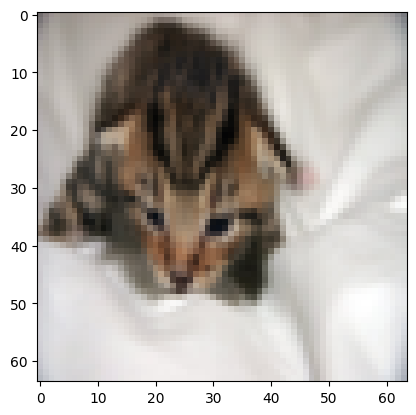

In [37]:
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

## Plotting the Cost Function

To understand how well the model is learning, we plot the **cost value over iterations**.

- `costs` is a list of cost values recorded every 100 iterations during training
- A smooth and decreasing curve indicates that the model is learning and converging properly

This visualization helps us:
- Diagnose if the learning rate is too high or too low
- Detect potential plateaus or instability in training


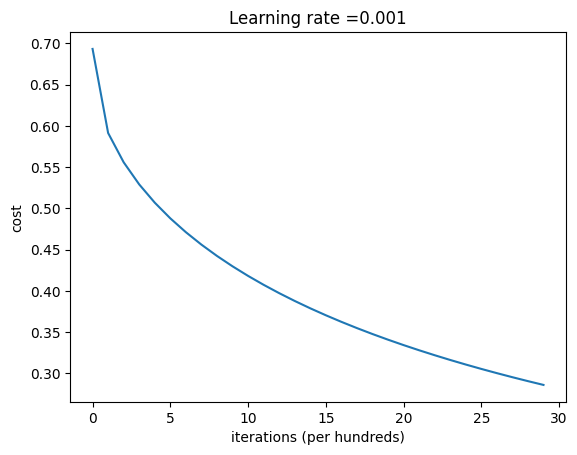

In [42]:
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

## Comparing Different Learning Rates

To understand the effect of the learning rate on training dynamics, we train three models using different learning rates:

- `0.01`
- `0.001`
- `0.0001`

Each model is trained for 1500 iterations, and the cost is recorded during training.

### What this analysis shows:
- A **high learning rate** may converge faster but risks overshooting or diverging
- A **low learning rate** may be more stable but can converge too slowly or get stuck

We plot the cost curves for each learning rate to visually compare their performance and convergence behavior.


Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



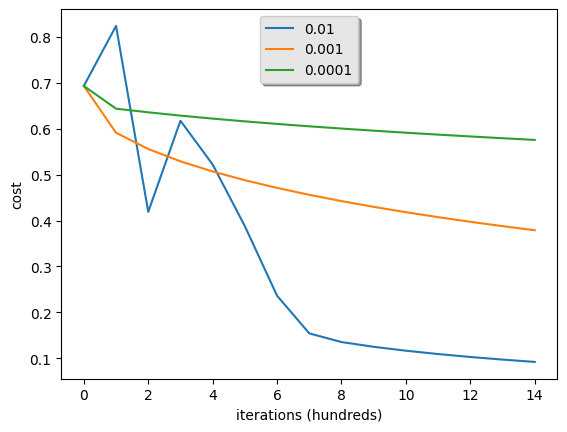

In [51]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## Hyperparameter Tuning - Grid Search

To find the best combination of `learning_rate` and `num_iterations`, we perform a simple **grid search** over predefined values:

- Learning rates: `[0.01, 0.005, 0.001]`
- Number of iterations: `[1000, 3000, 5000, 10000]`

For each combination, we:
1. Train the model
2. Evaluate the test set accuracy
3. Track the best-performing model

### Why this matters:
- A good learning rate can significantly speed up convergence without overshooting
- The right number of iterations ensures the model learns enough without overfitting

This strategy helps balance speed and performance.


In [52]:
learning_rates = [0.01, 0.005, 0.001]
iterations = [1000, 3000, 5000, 10000]

best_score = 0
best_modelo = None
best_parameters = {}

for lr in learning_rates:
    for iters in iterations:
        print(f"Testing lr={lr}, iter={iters}")
        modelo = model(train_set_x, train_set_y, test_set_x, test_set_y,
                       num_iterations=iters, learning_rate=lr, print_cost=False)
        
        acc = 100 - np.mean(np.abs(modelo["Y_prediction_test"] - test_set_y)) * 100
        
        if acc > best_score:
            best_score = acc
            best_modelo = modelo
            best_parameters = {
                "learning_rate": lr,
                "num_iterations": iters
            }

print("Best accuracy:", best_score)
print("Best parameters:", best_parameters)


Testing lr=0.01, iter=1000
Testing lr=0.01, iter=3000
Testing lr=0.01, iter=5000
Testing lr=0.01, iter=10000
Testing lr=0.005, iter=1000
Testing lr=0.005, iter=3000
Testing lr=0.005, iter=5000
Testing lr=0.005, iter=10000
Testing lr=0.001, iter=1000
Testing lr=0.001, iter=3000
Testing lr=0.001, iter=5000
Testing lr=0.001, iter=10000
Best accuracy: 74.0
Best parameters: {'learning_rate': 0.001, 'num_iterations': 3000}
